# Session 14_15: Dataset Statistics

1. Dataset kinds and its count
2. Each dataset size
3. Each dataset visualization
4. Mean and standard deviation calculation for dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [0]:
import os
import time
import numpy as np
import pandas as pd
import shutil
from tqdm import tqdm
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# For profile the processing and memory need
import pkgutil

if pkgutil.find_loader("memory_profiler") is None:
  !pip install memory_profiler

if pkgutil.find_loader("line_profiler") is None:
  !pip install line_profiler

%load_ext line_profiler
%load_ext memory_profiler

## Initialize dataset locations and get zip resources

In [0]:
# initialize dataset locations
root_dataset = "/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset"

bg_zipfile_name = f'{root_dataset}/bg_images.zip'                       # background images location
fg_zipfile_name = f'{root_dataset}/fg_images.zip'                       # foreground images location
fg_mask_zipfile_name = f'{root_dataset}/fg_mask_images.zip'             # forground mask images location
fg_bg_zipfile_name = f'{root_dataset}/fg_bg_images.zip'                 # forground-background overlay images location
#fg_bg_mask_bg_zipfile_name = f'{root_dataset}/fg_bg_mask_images.zip'    # forground-background overlay mask images location
fg_bg_mask_bg_c1_zipfile_name = f'{root_dataset}/fg_bg_mask_images_c1.zip'    # forground-background overlay mask images location-one channel mask
fg_bg_depth_zipfile_name = f'{root_dataset}/fg_bg_depth_images.zip'     # forground-background depth images location

In [0]:
# get zip resources
zf_bg = zipfile.ZipFile(bg_zipfile_name, 'r')
zf_fg = zipfile.ZipFile(fg_zipfile_name, 'r')
zf_fg_mask = zipfile.ZipFile(fg_mask_zipfile_name, 'r')
zf_fg_bg = zipfile.ZipFile(fg_bg_zipfile_name, 'r')
#zf_fg_bg_mask = zipfile.ZipFile(fg_bg_mask_bg_zipfile_name, 'r')
zf_fg_bg_mask_c1 = zipfile.ZipFile(fg_bg_mask_bg_c1_zipfile_name, 'r')
zf_fg_bg_depth = zipfile.ZipFile(fg_bg_depth_zipfile_name, 'r')

### Count for each kind of dataset

In [7]:
datasets = [["bg", len(zf_bg.namelist())],
            ["fg", len(zf_fg.namelist())],
            ["fg_mask", len(zf_fg_mask.namelist())],
            ["fg_bg", len(zf_fg_bg.namelist())],
            ["fg_bg_mask", len(zf_fg_bg_mask_c1.namelist())],
            ["fg_bg_depth", len(zf_fg_bg_depth.namelist())]]

df = pd.DataFrame(data=datasets, columns=["Kinds", "Total Images"])
df

,Kinds,Total Images
0,bg,100
1,fg,100
2,fg_mask,100
3,fg_bg,400000
4,fg_bg_mask,400000
5,fg_bg_depth,400000


## Visualize all kind of dataset

In [0]:
def read_image_from_zip(zf, filename):
    data = zf.read(filename)
    dataEnc = BytesIO(data)
    img = Image.open(dataEnc)
    return img
		
def load_images_from_zip(zf, im_files):
    load_images = []
    for file in im_files:
      img = read_image_from_zip(zf, file)
      load_images.append(img)

    #return np.stack(load_images, axis=0)
    return load_images

In [9]:
# filename for 10 different foreground and background images
randnums= np.random.randint(1,101,10)
img_files = [f'img_{idx:03d}.jpg' for idx in randnums]
overlay_files = [f'fg{idx:03d}_bg{idx:03d}_01.jpg' for idx in randnums]
print("Random filename choosen for bg, fg, fg_mask: \n", img_files)
print("\nRandom filename choosen for fg_bg, fg_bg_mask, fg_bg_depth: \n", overlay_files)

Random filename choosen for bg, fg, fg_mask: 
 ['img_030.jpg', 'img_061.jpg', 'img_041.jpg', 'img_091.jpg', 'img_082.jpg', 'img_076.jpg', 'img_039.jpg', 'img_031.jpg', 'img_013.jpg', 'img_070.jpg']

Random filename choosen for fg_bg, fg_bg_mask, fg_bg_depth: 
 ['fg030_bg030_01.jpg', 'fg061_bg061_01.jpg', 'fg041_bg041_01.jpg', 'fg091_bg091_01.jpg', 'fg082_bg082_01.jpg', 'fg076_bg076_01.jpg', 'fg039_bg039_01.jpg', 'fg031_bg031_01.jpg', 'fg013_bg013_01.jpg', 'fg070_bg070_01.jpg']


In [0]:
# load image data
bg_data = load_images_from_zip(zf_bg, img_files)
fg_data = load_images_from_zip(zf_fg, img_files)
fg_mask_data = load_images_from_zip(zf_fg_mask, img_files)
fg_bg_data = load_images_from_zip(zf_fg_bg, overlay_files)
fg_bg_mask_data = load_images_from_zip(zf_fg_bg_mask_c1, overlay_files)
fg_bg_depth_data = load_images_from_zip(zf_fg_bg_depth, overlay_files)

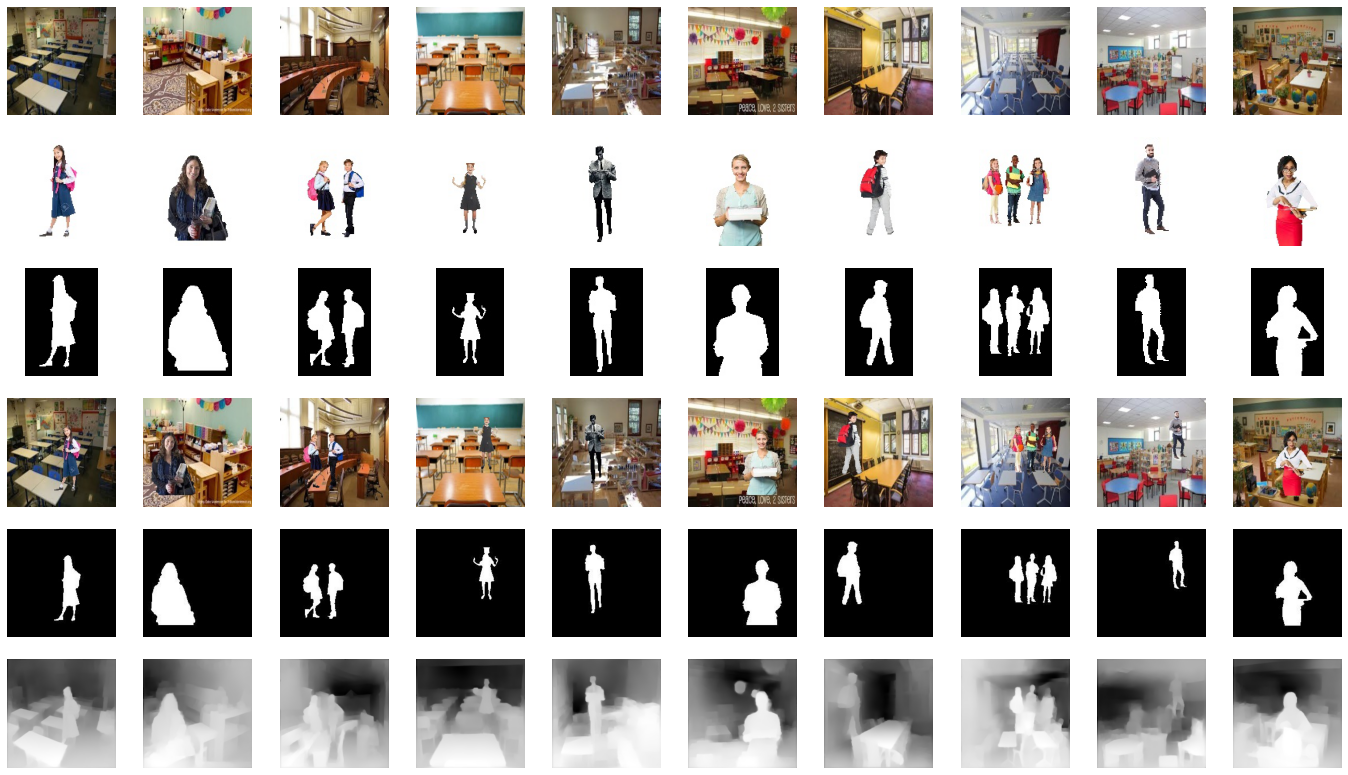

In [11]:
plt.figure(figsize=(24,14)) 

for i in np.arange(10): 
    plt.subplot(6,10,i+1),plt.imshow(bg_data[i])
    plt.axis('off')

for i in np.arange(10):
    plt.subplot(6,10, i+11),plt.imshow(fg_data[i])
    plt.axis('off')

for i in np.arange(10):
    plt.subplot(6,10, i+21),plt.imshow(fg_mask_data[i].convert('LA'))
    plt.axis('off')

for i in np.arange(10):
    plt.subplot(6,10, i+31),plt.imshow(fg_bg_data[i])
    plt.axis('off')

for i in np.arange(10):
    plt.subplot(6,10, i+41),plt.imshow(fg_bg_mask_data[i].convert('LA'))
    plt.axis('off')

for i in np.arange(10):
    plt.subplot(6,10, i+51),plt.imshow(fg_bg_depth_data[i].convert('LA'))
    plt.axis('off')

plt.savefig("dataset_visual.jpg")
plt.show()


## Dataset size for each kind

In [0]:
def get_dataset_size(zf):
  datasize = sum([zinfo.file_size for zinfo in  zf.filelist])
  return np.round(datasize / 1e+6, 3)

In [0]:
bg_size = get_dataset_size(zf_bg)
fg_size = get_dataset_size(zf_fg)
fg_mask_size = get_dataset_size(zf_fg_mask)
fg_bg_size = get_dataset_size(zf_fg_bg)
fg_bg_mask_size = get_dataset_size(zf_fg_bg_mask_c1)
fg_bg_depth_size = get_dataset_size(zf_fg_bg_depth)

In [14]:
df["Total Size (MB)"] = [bg_size, fg_size, fg_mask_size, fg_bg_size, fg_bg_mask_size, fg_bg_depth_size]
df

,Kinds,Total Images,Total Size (MB)
0,bg,100,1.888
1,fg,100,0.456
2,fg_mask,100,0.289
3,fg_bg,400000,7941.210
4,fg_bg_mask,400000,846.108
5,fg_bg_depth,400000,3237.788


## Image Dimensions

In [0]:
bg_shape = np.array(bg_data[0]).shape
fg_shape = np.array(fg_data[0]).shape
fg_mask_shape = np.array(fg_mask_data[0]).shape
fg_bg_shape = np.array(fg_bg_data[0]).shape
fg_bg_mask_shape = np.array(fg_bg_mask_data[0]).shape
fg_bg_depth_shape = np.array(fg_bg_depth_data[0]).shape

In [16]:
print(f'bg_shape: {bg_shape}')
print(f'fg_shape: {fg_shape}')
print(f'fg_mask_shape: {fg_mask_shape}')
print(f'fg_bg_shape: {fg_bg_shape}')
print(f'fg_bg_mask_shape: {fg_bg_mask_shape}')
print(f'fg_bg_depth_shape: {fg_bg_depth_shape}')

bg_shape: (192, 192, 3)
fg_shape: (137, 91, 3)
fg_mask_shape: (137, 91)
fg_bg_shape: (192, 192, 3)
fg_bg_mask_shape: (192, 192)
fg_bg_depth_shape: (240, 240)


In [17]:
df["Image Dimension"] = [bg_shape[:-1], "size of an object in image", "same as fg image", fg_bg_shape[:-1], fg_bg_mask_shape, fg_bg_depth_shape]
df["Channels"] =  [bg_shape[2], fg_shape[2], 1, fg_bg_shape[2], 1, 1]
df

,Kinds,Total Images,Total Size (MB),Image Dimension,Channels
0,bg,100,1.888,"(192, 192)",3
1,fg,100,0.456,size of an object in image,3
2,fg_mask,100,0.289,same as fg image,1
3,fg_bg,400000,7941.210,"(192, 192)",3
4,fg_bg_mask,400000,846.108,"(192, 192)",1
5,fg_bg_depth,400000,3237.788,"(240, 240)",1


## Mean/STD calculations for dataset

In [0]:
from tqdm import tqdm

'''
1. Calculate means for dataset using batch approach
2. useful for large dataset
3. calculating mean for 400K dataset by loading all the images need high amout of RAM.
First sum of pixels values are calculate in batched and then mean of all the sums are taken to calculate mean
'''

def calc_means(zf, img_size, channels, b_size):
    
    num_images = len(zf.namelist())
    file_list = zf.namelist()
    
    means = []   
    sums = [0, 0, 0]

    b_cnt = num_images // b_size

    pbar = tqdm(np.arange(b_cnt))
    for i in pbar:
      # load images     
      img_data = np.zeros((b_size, img_size, img_size, channels), dtype='float32')
      for k in np.arange(b_size):
        filename = file_list[b_size*i+k]
        im = read_image_from_zip(zf, filename)
        if channels == 1:
          img_data[k] = np.expand_dims(im, axis=2)
        else:
          img_data[k] = im

      # channel sums
      for c in np.arange(channels): 
          pixels = img_data[:,:,:,c].ravel()
          sums[c] += np.sum(pixels)

      del img_data
      pbar.set_description(desc= f'[Means] Processing: {(i+1)*b_size}/{num_images}')
    
    # calculate mean
    total_pixels = img_size*img_size*num_images
    for c in np.arange(channels):  
      means.append(sums[c]/total_pixels) 

    return np.round(means,4)

'''
1. Calculate standard deviation for dataset using batch approach
2. useful for large dataset
3. calculating std for 400K dataset by loading all the images need high amout of RAM.
First mean of dataset is calculated in batches. then this mean is used for calculated sum of square of (pixel-mean) in batched.
and finally std is calculated
'''

def calc_stds(zf, means, img_size, channels, b_size):
    
    num_images = len(zf.namelist())
    file_list = zf.namelist()
    
    stdevs = []
    sum_square = [0, 0, 0]

    b_cnt = num_images // b_size

    pbar = tqdm(np.arange(b_cnt))
    for i in pbar:   
      # load images     
      img_data = np.zeros((b_size, img_size, img_size, channels), dtype='float32')
      for k in np.arange(b_size):
        filename = file_list[b_size*i+k]
        im = read_image_from_zip(zf, filename)
        if channels == 1:
          img_data[k] = np.expand_dims(im, axis=2)
        else:
          img_data[k] = im

      # sume of square(pixel-mean)
      for c in np.arange(channels): 
        pixels = img_data[:,:,:,c].ravel()
        sum_square[c] += np.sum(np.power(pixels-means[c],2))

      del img_data

      pbar.set_description(desc= f'[Stds] Processing: {(i+1)*b_size}/{num_images}')
    
    # calculate stds
    total_pixels = img_size*img_size*num_images
    for c in np.arange(channels):     
      stdevs.append(np.sqrt(sum_square[c]/total_pixels)) 

    return np.round(stdevs,4)

'''
calculating mean for 400K dataset by load all the images need high amout of RAM.
so mean is calculated in batches. inividual batch means is used to find the net mean of entire dataset
'''
def calc_means_and_stds(zf, img_size, channels):
    
    num_images = len(zf.namelist())
    file_list = zf.namelist()
   
    means = []
    stdevs = []   
  
    # load images     
    img_data = np.zeros((num_images, img_size, img_size, channels), dtype='float32')
    for idx, filename in enumerate(file_list):
      im = read_image_from_zip(zf, filename)
      if channels == 1:
        img_data[idx] = np.expand_dims(im, axis=2)
      else:
        img_data[idx] = im

      del im

    # calculate mean for this batch of images
    for c in np.arange(channels): 
      pixels = img_data[:,:,:,c].ravel()
      means.append(np.mean(pixels))
      stdevs.append(np.std(pixels))

    del img_data
        
    return means, stdevs

In [19]:
# free unused memory
import gc
gc.collect()

107736

In [0]:
# calculate mean for bg dataset
#bg_means, bg_stds = calc_means_and_stds(zf_bg, img_size=bg_shape[0], channels=3)
#print(f"bg dataset: Means: {bg_means}, Stds: {bg_stds}")

In [21]:
# calculate mean and std for bg dataset
%%time
%%memit

zf = zf_bg
img_size = bg_shape[0]
channels=3
b_size=10

bg_means = calc_means(zf, img_size=img_size, channels=channels, b_size=b_size)
bg_stds = calc_stds(zf, bg_means, img_size=img_size, channels=channels, b_size=b_size)
print(f"\n\nbg dataset: Means: {bg_means}, Stds: {bg_stds}\n")

[Stds] Processing: 100/100: 100%|██████████| 10/10 [00:00<00:00, 30.65it/s]




bg dataset: Means: [142.3604 129.986  115.9921], Stds: [65.6258 64.9718 65.5989]

peak memory: 1127.56 MiB, increment: 0.13 MiB
CPU times: user 940 ms, sys: 32.4 ms, total: 973 ms
Wall time: 1.11 s


In [22]:
# calculate mean for fg_bg dataset
%%time
%%memit

zf = zf_fg_bg
img_size = fg_bg_shape[0]
channels=3
b_size=1000

fg_bg_means = calc_means(zf, img_size=img_size, channels=channels, b_size=b_size)
fg_bg_stds = calc_stds(zf, fg_bg_means, img_size=img_size, channels=channels, b_size=b_size)
print(f"\n\nfg_bg dataset: Means: {fg_bg_means}, Stds: {fg_bg_stds}\n")

[Stds] Processing: 400000/400000: 100%|██████████| 400/400 [19:59<00:00,  3.00s/it]



fg_bg dataset: Means: [142.8615 130.0039 117.2206], Stds: [66.4145 65.5184 66.0169]

peak memory: 1927.91 MiB, increment: 800.36 MiB
CPU times: user 28min 11s, sys: 19.7 s, total: 28min 31s
Wall time: 28min 59s


In [23]:
# calculate mean for fg_bg_mask dataset
%%time
%%memit

zf = zf_fg_bg_mask_c1
img_size = fg_bg_mask_shape[0]
channels=1
b_size=1000

fg_bg_mask_means = calc_means(zf, img_size=img_size, channels=channels, b_size=b_size)
fg_bg_mask_stds = calc_stds(zf, fg_bg_mask_means, img_size=img_size, channels=channels, b_size=b_size)
print(f"\n\nfg_bg_mask dataset: Means: {fg_bg_mask_means}, Stds: {fg_bg_mask_stds}\n")

[Stds] Processing: 400000/400000: 100%|██████████| 400/400 [05:53<00:00,  1.13it/s]



fg_bg_mask dataset: Means: [23.2702], Stds: [72.9364]

peak memory: 1894.69 MiB, increment: 5.43 MiB
CPU times: user 7min 47s, sys: 7.25 s, total: 7min 55s
Wall time: 7min 56s


In [24]:
# calculate mean for fg_bg_depth dataset
%%time
%%memit

zf = zf_fg_bg_depth
img_size = fg_bg_depth_shape[0]
channels=1
b_size=1000

fg_bg_depth_means = calc_means(zf, img_size=img_size, channels=channels, b_size=b_size)
fg_bg_depth_stds = calc_stds(zf, fg_bg_depth_means, img_size=img_size, channels=channels, b_size=b_size)
print(f"\n\nfg_bg_depth dataset: Means: {fg_bg_depth_means}, Stds: {fg_bg_depth_stds}\n")

[Stds] Processing: 400000/400000: 100%|██████████| 400/400 [09:18<00:00,  1.40s/it]



fg_bg_depth dataset: Means: [147.4633], Stds: [72.0034]

peak memory: 1831.43 MiB, increment: 6.02 MiB
CPU times: user 12min 51s, sys: 8.07 s, total: 12min 59s
Wall time: 13min 11s


In [25]:
df["Means"] = [bg_means, np.nan, np.nan, fg_bg_means,fg_bg_mask_means,fg_bg_depth_means]
df["Stds"] = [bg_stds, np.nan, np.nan, fg_bg_stds,fg_bg_mask_stds,fg_bg_depth_stds]
df

,Kinds,Total Images,Total Size (MB),Image Dimension,Channels,Means,Stds
0,bg,100,1.888,"(192, 192)",3,"[142.3604, 129.986, 115.9921]","[65.6258, 64.9718, 65.5989]"
1,fg,100,0.456,size of an object in image,3,NaN,NaN
2,fg_mask,100,0.289,same as fg image,1,NaN,NaN
3,fg_bg,400000,7941.210,"(192, 192)",3,"[142.8615, 130.0039, 117.2206]","[66.4145, 65.5184, 66.0169]"
4,fg_bg_mask,400000,846.108,"(192, 192)",1,[23.2702],[72.9364]
5,fg_bg_depth,400000,3237.788,"(240, 240)",1,[147.4633],[72.0034]


### Save Statistic

In [0]:
# keep record of entire dataset for later use
df.to_csv("dataset_summary.csv")

## Important: release all resources

In [0]:
# close the zip file resource
zf_bg.close()
zf_fg.close()
zf_fg_mask.close()
zf_fg_bg.close()
#zf_fg_bg_mask.close()
zf_fg_bg_mask_c1.close()
zf_fg_bg_depth.close()